# 15. 다양한 OCR 모델 비교하기

keras-ocr, Tesseract 2가지의 OCR을 검증하는 프로젝트를 진행해보자.   

외국 여행 과정에서 그 나라에 있는 음식점을 들리는건 외국의 분위기를 느끼기에 그리고 밥을 잘 챙겨먹기 위해 꼭 필요한 필수 코스라고 생각한다. 하지만 외국어를 못한다면 많이 난처할것이다. 그래서 이번에 정한 주제는 메뉴판을 제대로 인식하는지 파악하는 것이다.   
외국어를 번역하기 직전 메뉴판을 보고 해당 언어를 제대로 detection과 recognition을 하는지에 대한 OCR 성능을 중점으로 볼 예정이다.

먼저 라이브러리를 불러오자.

In [1]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from pytesseract import Output

In [3]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


# 15-1. 검증용 데이터셋 준비

In [4]:
image_path = os.getenv('HOME')+'/aiffel/ocr_python/menu_dataset/*'
filenames = tf.io.gfile.glob(image_path)

/aiffel/aiffel/ocr_python/menu_dataset/andersen-jensen-Hk2eu3OODdg-unsplash Medium.jpeg


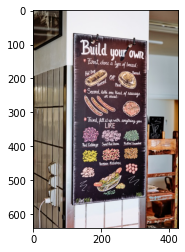

/aiffel/aiffel/ocr_python/menu_dataset/vladimir-kudinov-IRk0uUSptYg-unsplash Medium.jpeg


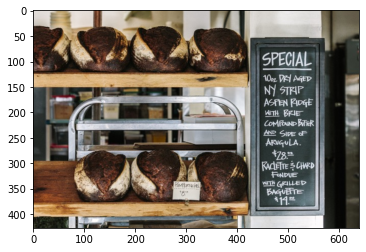

/aiffel/aiffel/ocr_python/menu_dataset/nathan-dumlao-OWysG_PxFso-unsplash Medium.jpeg


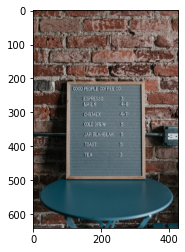

/aiffel/aiffel/ocr_python/menu_dataset/6E_JPEG_DSC07626.jpg


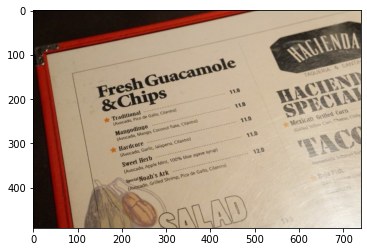

/aiffel/aiffel/ocr_python/menu_dataset/nathan-dumlao-5-tl8DLvYA4-unsplash Medium.jpeg


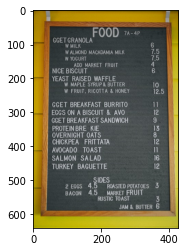

/aiffel/aiffel/ocr_python/menu_dataset/nienke-broeksema-_hiPJ6Z0vao-unsplash Medium.jpeg


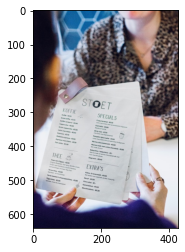

/aiffel/aiffel/ocr_python/menu_dataset/shay-gordon-JeOjt07kkCU-unsplash Medium.jpeg


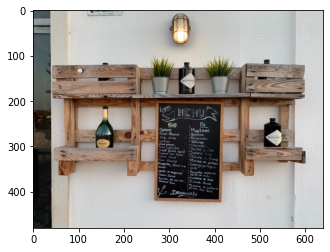

/aiffel/aiffel/ocr_python/menu_dataset/jonathan-borba-21tOEaJPM_o-unsplash Medium.jpeg


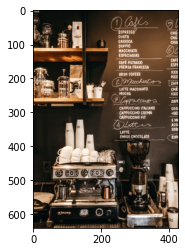

/aiffel/aiffel/ocr_python/menu_dataset/rooted-studio-cxshyEj_5Vw-unsplash Medium.jpeg


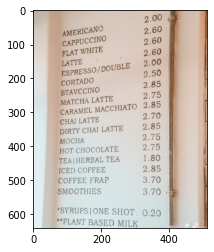

/aiffel/aiffel/ocr_python/menu_dataset/kelly-mccrimmon-YskopWE0zEk-unsplash Medium.jpeg


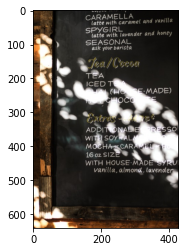

/aiffel/aiffel/ocr_python/menu_dataset/freddy-do-EkmB2O8vr2o-unsplash Medium.jpeg


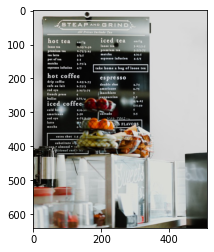

/aiffel/aiffel/ocr_python/menu_dataset/nathan-dumlao-ulPd2UCwZYk-unsplash Medium.jpeg


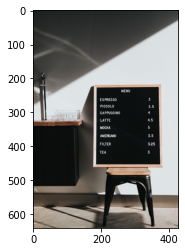

/aiffel/aiffel/ocr_python/menu_dataset/charles-postiaux-vTeRJtGYB-o-unsplash Medium.jpeg


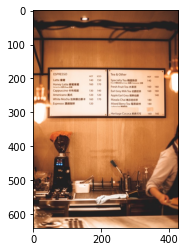

/aiffel/aiffel/ocr_python/menu_dataset/avatyler-fSTjfMQ44YU-unsplash Medium.jpeg


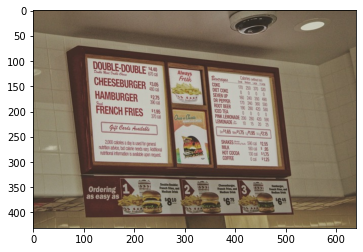

In [5]:
for i in range(14):
    print(filenames[i])
    img_orig = cv2.imread(filenames[i])
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

총 14개의 메뉴판 image를 준비했다.

# 15-2. 이미지 테스트 진행

### keras-ocr 사용하기

텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 OCR이다. 

In [6]:
image_urls = []
for i in range(14):
    image_urls.append(filenames[i])

images = [keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

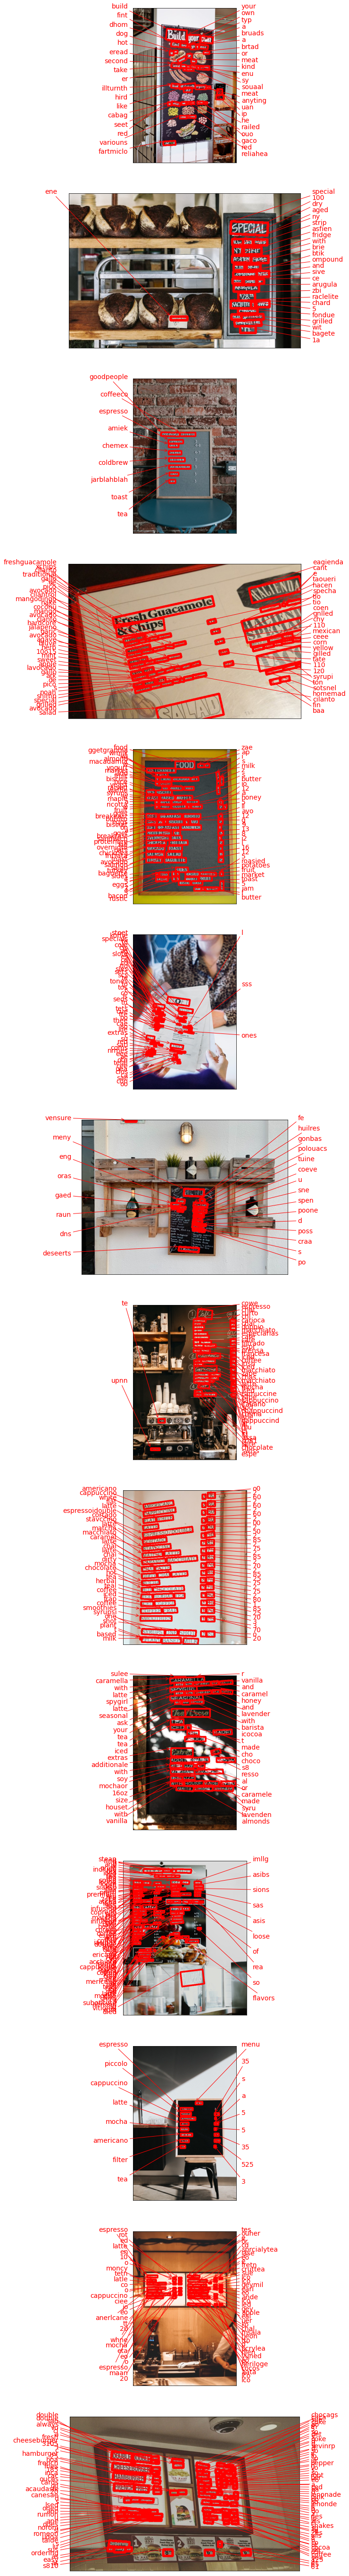

In [7]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract 사용하기

구글에서 후원하는 OCR 오픈소스 라이브러리다. 이미지 내에 문자 검출과 인식을 한 번에 할 수 있다.

In [8]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

### tesseract로 잘린 이미지에서 단어 인식하기
영역별 텍스트가 결과값으로 나오는 `image_to_string()` 사용하기

In [9]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

> 아래 tesseract를 진행하는데 파일별로 detect이 제대로 안되는 경우가 생기면 검출이 멈추는 상황이 발견했다. 그래서 가능한 사진들만 보기 위해 하드코딩을 진행했다.

하드코딩으로 `i`를 0~13까지 진행했다. 6은 아예 오류가 나와서 제외하고 진행했다.

In [10]:
for i in range(1, 5):
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_result{}'.format(i) # crop된 결과 저장 경로
    print(filenames[i])
    img_file_path = filenames[i]
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
    # 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력한다.
    recognize_images(cropped_image_path_list)
    
for i in range(6, 14):
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_result{}'.format(i) # crop된 결과 저장 경로
    print(filenames[i])
    img_file_path = filenames[i]
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
    # 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력한다.
    recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/menu_dataset/vladimir-kudinov-IRk0uUSptYg-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/tesseract_result1/0000.png

Done
/aiffel/aiffel/ocr_python/menu_dataset/nathan-dumlao-OWysG_PxFso-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/tesseract_result2/0000.png
/aiffel/aiffel/ocr_python/tesseract_result2/0001.png
/aiffel/aiffel/ocr_python/tesseract_result2/0002.png
/aiffel/aiffel/ocr_python/tesseract_result2/0003.png
/aiffel/aiffel/ocr_python/tesseract_result2/0004.png
/aiffel/aiffel/ocr_python/tesseract_result2/0005.png
/aiffel/aiffel/ocr_python/tesseract_result2/0006.png
CHEME,

>,

ihe a0 a5)

VAR GLANDLAF

(dy.

iy.

;

Done
/aiffel/aiffel/ocr_python/menu_dataset/6E_JPEG_DSC07626.jpg
/aiffel/aiffel/ocr_python/tesseract_result3/0000.png
/aiffel/aiffel/ocr_python/tesseract_result3/0001.png
/aiffel/aiffel/ocr_python/tesseract_result3/0002.png
/aiffel/aiffel/ocr_python/tesseract_result3/0003.png
/aiffel/aiffel/ocr_python/tesseract_result3/0004.png
/aiff

_ -

f""

ies i

Done
/aiffel/aiffel/ocr_python/menu_dataset/jonathan-borba-21tOEaJPM_o-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/tesseract_result7/0000.png
/aiffel/aiffel/ocr_python/tesseract_result7/0001.png
/aiffel/aiffel/ocr_python/tesseract_result7/0002.png
/aiffel/aiffel/ocr_python/tesseract_result7/0003.png
/aiffel/aiffel/ocr_python/tesseract_result7/0004.png
/aiffel/aiffel/ocr_python/tesseract_result7/0005.png
CG

[

rf

:

:

ry

Done
/aiffel/aiffel/ocr_python/menu_dataset/rooted-studio-cxshyEj_5Vw-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/tesseract_result8/0000.png
/aiffel/aiffel/ocr_python/tesseract_result8/0001.png
/aiffel/aiffel/ocr_python/tesseract_result8/0002.png
/aiffel/aiffel/ocr_python/tesseract_result8/0003.png
/aiffel/aiffel/ocr_python/tesseract_result8/0004.png
/aiffel/aiffel/ocr_python/tesseract_result8/0005.png
/aiffel/aiffel/ocr_python/tesseract_result8/0006.png
/aiffel/aiffel/ocr_python/tesseract_result8/0007.png
/aiffel/aiffel/ocr_python/te

~ r

.

ESPRESSO

A

Creal

ee

Waal ee

1

wei:

a

ar

_

oa

>

miai3)

Was

Done
/aiffel/aiffel/ocr_python/menu_dataset/charles-postiaux-vTeRJtGYB-o-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/tesseract_result12/0000.png
" 3 1

Done
/aiffel/aiffel/ocr_python/menu_dataset/avatyler-fSTjfMQ44YU-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/tesseract_result13/0000.png
/aiffel/aiffel/ocr_python/tesseract_result13/0001.png
/aiffel/aiffel/ocr_python/tesseract_result13/0002.png
/aiffel/aiffel/ocr_python/tesseract_result13/0003.png
/aiffel/aiffel/ocr_python/tesseract_result13/0004.png
/aiffel/aiffel/ocr_python/tesseract_result13/0005.png
/aiffel/aiffel/ocr_python/tesseract_result13/0006.png
/aiffel/aiffel/ocr_python/tesseract_result13/0007.png
/aiffel/aiffel/ocr_python/tesseract_result13/0008.png
/aiffel/aiffel/ocr_python/tesseract_result13/0009.png
/aiffel/aiffel/ocr_python/tesseract_result13/0010.png
/aiffel/aiffel/ocr_python/tesseract_result13/0011.png
/aiffel/aiffel

In [11]:
for i in range(14):
    print('{},{}'.format(i, filenames[i]))

0,/aiffel/aiffel/ocr_python/menu_dataset/andersen-jensen-Hk2eu3OODdg-unsplash Medium.jpeg
1,/aiffel/aiffel/ocr_python/menu_dataset/vladimir-kudinov-IRk0uUSptYg-unsplash Medium.jpeg
2,/aiffel/aiffel/ocr_python/menu_dataset/nathan-dumlao-OWysG_PxFso-unsplash Medium.jpeg
3,/aiffel/aiffel/ocr_python/menu_dataset/6E_JPEG_DSC07626.jpg
4,/aiffel/aiffel/ocr_python/menu_dataset/nathan-dumlao-5-tl8DLvYA4-unsplash Medium.jpeg
5,/aiffel/aiffel/ocr_python/menu_dataset/nienke-broeksema-_hiPJ6Z0vao-unsplash Medium.jpeg
6,/aiffel/aiffel/ocr_python/menu_dataset/shay-gordon-JeOjt07kkCU-unsplash Medium.jpeg
7,/aiffel/aiffel/ocr_python/menu_dataset/jonathan-borba-21tOEaJPM_o-unsplash Medium.jpeg
8,/aiffel/aiffel/ocr_python/menu_dataset/rooted-studio-cxshyEj_5Vw-unsplash Medium.jpeg
9,/aiffel/aiffel/ocr_python/menu_dataset/kelly-mccrimmon-YskopWE0zEk-unsplash Medium.jpeg
10,/aiffel/aiffel/ocr_python/menu_dataset/freddy-do-EkmB2O8vr2o-unsplash Medium.jpeg
11,/aiffel/aiffel/ocr_python/menu_dataset/nathan-dum

# 15-3. 이미지 테스트 결과 정리

### Tesseract로 문제가 있는 파일명

In [12]:
print(filenames[0]) # 제대로 검출이 안되고 결과가 파일 통째로 나옴
print(filenames[1]) # 제대로 검출이 안되고 결과가 파일 통째로 나옴
print(filenames[5]) # SystemError: tile cannot extend outside image
print(filenames[6]) # detect이 제대로 안됐음
print(filenames[7]) # detect이 제대로 안됐음
print(filenames[10]) # detect이 제대로 안됐음
print(filenames[12]) # 제대로 검출이 안되고 결과가 파일 통째로 나옴
print(filenames[13]) # detect이 제대로 안됐음

/aiffel/aiffel/ocr_python/menu_dataset/andersen-jensen-Hk2eu3OODdg-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/menu_dataset/vladimir-kudinov-IRk0uUSptYg-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/menu_dataset/nienke-broeksema-_hiPJ6Z0vao-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/menu_dataset/shay-gordon-JeOjt07kkCU-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/menu_dataset/jonathan-borba-21tOEaJPM_o-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/menu_dataset/freddy-do-EkmB2O8vr2o-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/menu_dataset/charles-postiaux-vTeRJtGYB-o-unsplash Medium.jpeg
/aiffel/aiffel/ocr_python/menu_dataset/avatyler-fSTjfMQ44YU-unsplash Medium.jpeg


# 15-4. 결과 분석 및 결론 제시

__1. 검증용 데이터셋 준비__   
OCR 관련해서 텍스트의 모양, 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들을 배워봤다. 위 3가지의 OCR 모델들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize 하는지 검증하기 위한 이미지 데이터를 모아야한다. 위 성능에 미치는 요인들을 고려해서 20장을 넘기지 않게 데이터셋을 모아보자. 

__2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택사항)__   
이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아보자. Google OCR API는 선택사항이다.

__3. 테스트 결과 정리__   
모듈들마다 출력 형태가 다르다. 분석을 위해 결과를 정리해보자. 시각화 방법을 활용하면 더욱 좋아보인다.

__4. 결과 분석과 결론 제시__   
구현하고자 하는 서비스의 목적과 내용을 정리해보자. 그리고 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 평가 기준을 제시하고, 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정해보자.

# 회고